In [1]:
"""Example showing the use of SOCEMO for multi-objective optimization"""

# Copyright (c) 2024 Alliance for Sustainable Energy, LLC

# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <http://www.gnu.org/licenses/>.

__authors__ = ["Weslley S. Pereira"]
__contact__ = "weslley.dasilvapereira@nrel.gov"
__maintainer__ = "Weslley S. Pereira"
__email__ = "weslley.dasilvapereira@nrel.gov"
__credits__ = ["Weslley S. Pereira"]
__version__ = "0.4.2"
__deprecated__ = False

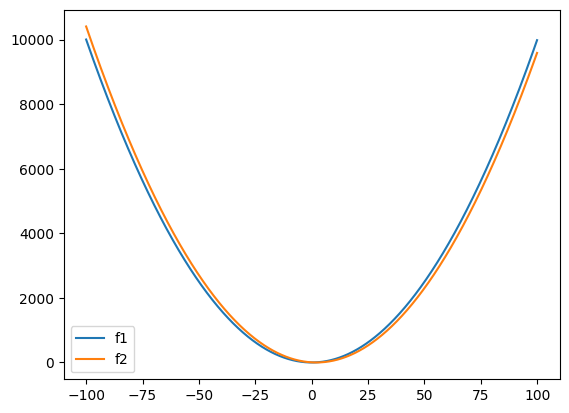

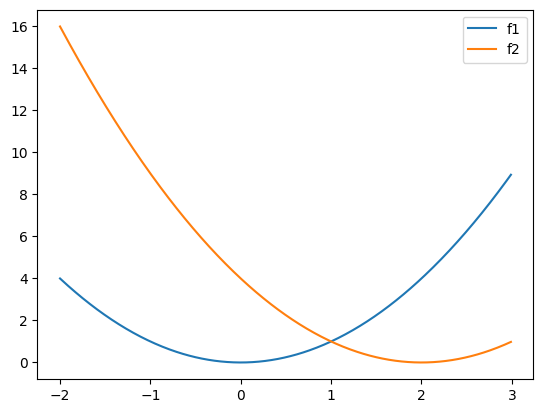

In [2]:
# Problem description
from matplotlib import pyplot as plt
import numpy as np

bounds = [(-100, 100)]


def objf(x):
    return [[xi[0] ** 2, (xi[0] - 2) ** 2] for xi in x]


x = np.arange(-100, 100, 0.1)
fx = objf([[xi] for xi in x])
f1x = [f[0] for f in fx]
f2x = [f[1] for f in fx]
plt.plot(x, f1x, label="f1")
plt.plot(x, f2x, label="f2")
plt.legend()
plt.show()

x = np.arange(-2, 3, 0.01)
fx = objf([[xi] for xi in x])
f1x = [f[0] for f in fx]
f2x = [f[1] for f in fx]
plt.plot(x, f1x, label="f1")
plt.plot(x, f2x, label="f2")
plt.legend()
plt.show()

In [3]:
from blackboxopt.rbf import RbfModel
from blackboxopt.acquisition import WeightedAcquisition
from blackboxopt.sampling import NormalSampler, Sampler

maxeval = 100
ncand = 500
sigma = 0.02
tol = 0.001

localAcquisition = WeightedAcquisition(
    NormalSampler(ncand, sigma), weightpattern=0.95, reltol=tol, maxeval=maxeval, 
)
globalAcquisition = WeightedAcquisition(Sampler(ncand), 0.95, tol)

In [4]:
# Declare variable for the linter
outputSOCEMO = None

In [5]:
%%capture outputSOCEMO
from blackboxopt.optimize import socemo

np.random.seed(3)

surrogateModels = [RbfModel(), RbfModel()]
res = socemo(
    objf,
    bounds,
    maxeval,
    surrogateModels=surrogateModels,
    acquisitionFunc=localAcquisition,
    acquisitionFuncGlobal=globalAcquisition,
    disp=True,
)

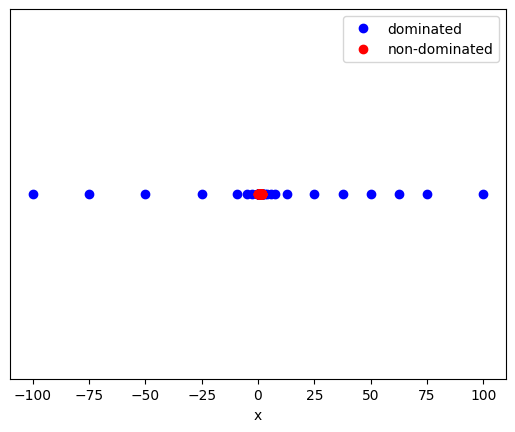

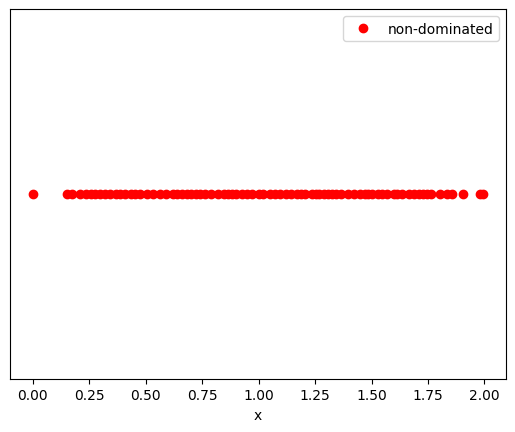

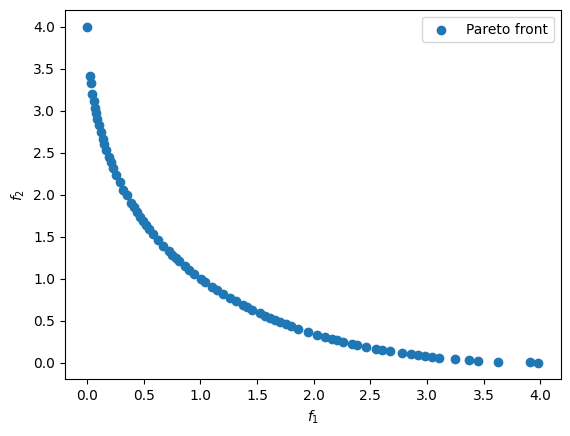

In [6]:
from matplotlib import pyplot as plt

sample = res.sample.flatten()
f1 = res.fsample[:, 0].flatten()
f2 = res.fsample[:, 1].flatten()
nondominated = res.x
paretoFront = res.fx

plt.plot(sample, np.ones_like(sample), "bo", label="dominated")
# plt.plot(sample, f2, 'bo')
plt.plot(nondominated, np.ones_like(nondominated), "ro", label="non-dominated")
# plt.plot(nondominated, paretoFront[:,1], 'ro')
plt.xlabel("x")
plt.yticks([], [])
plt.legend()
plt.show()

plt.plot(nondominated, np.ones_like(nondominated), "ro", label="non-dominated")
# plt.plot(nondominated, paretoFront[:,1], 'ro')
plt.xlabel("x")
plt.yticks([], [])
plt.legend()
plt.show()

# plt.scatter(res.fsample[:, 0], res.fsample[:, 1], label="Sample")
plt.scatter(res.fx[:, 0], res.fx[:, 1], label="Pareto front")
plt.xlabel(r"$f_1$")
plt.ylabel(r"$f_2$")
plt.legend()
plt.show()

In [7]:
out = outputSOCEMO.stdout.split("\n")

sampleUpToIter = []
for i in range(len(out)):
    if "fEvals:" in out[i]:
        sampleUpToIter.append(int(out[i].split()[1]))
sampleUpToIter.append(maxeval)

sampleUpToIter

[4, 12, 21, 29, 40, 56, 68, 78, 91, 100]

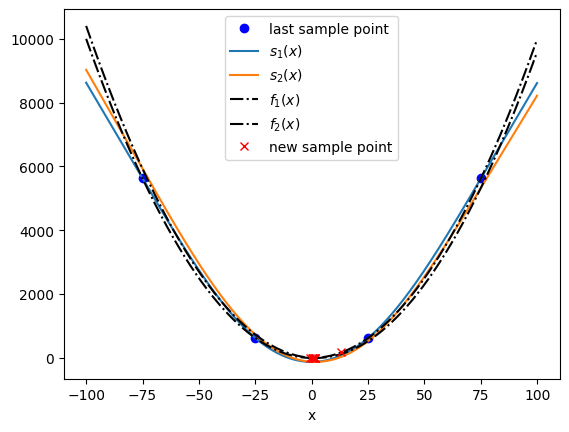

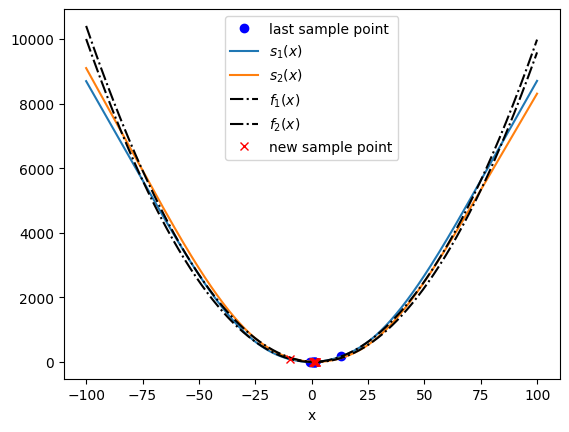

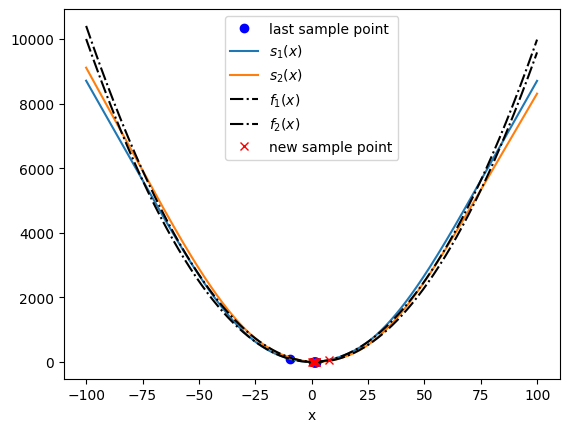

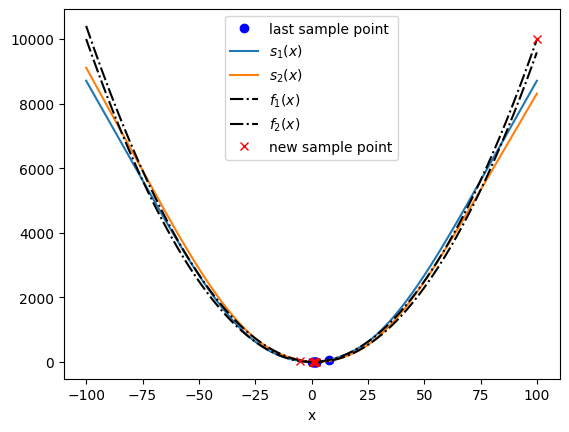

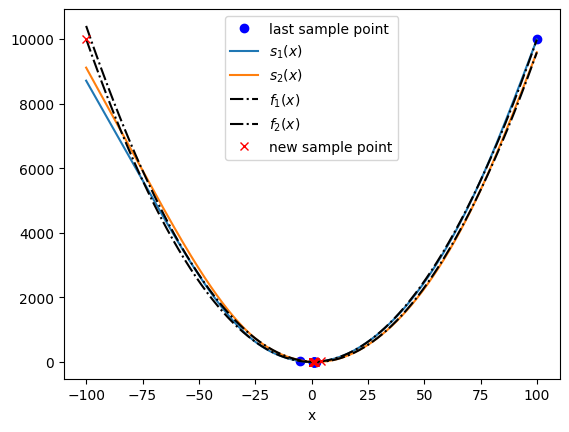

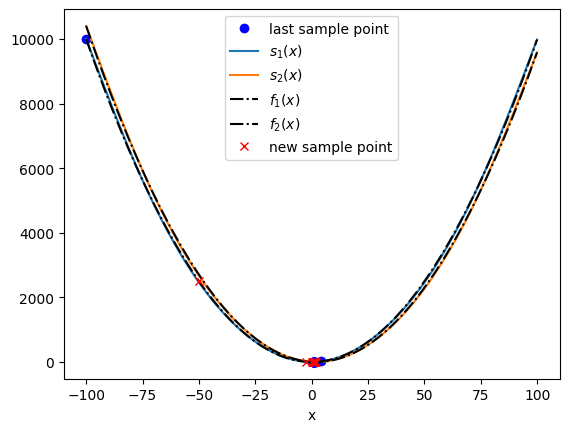

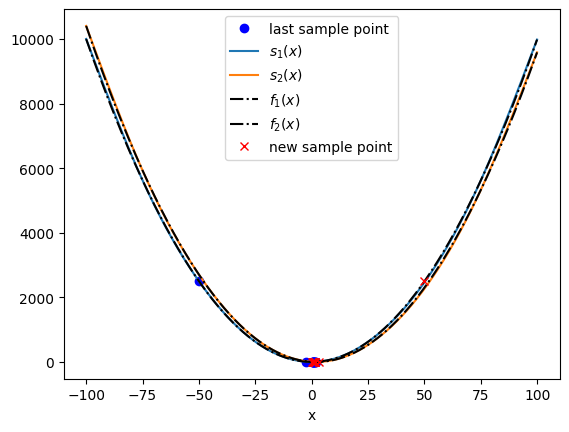

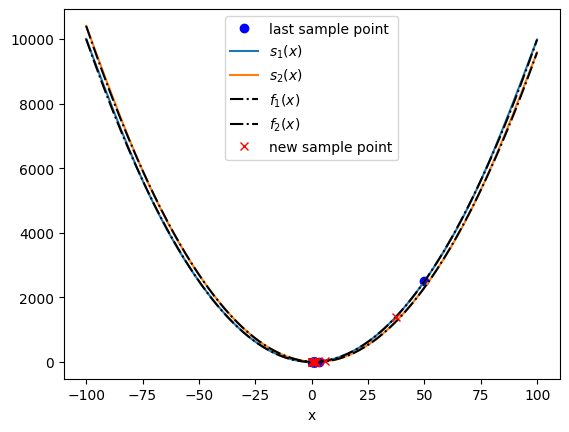

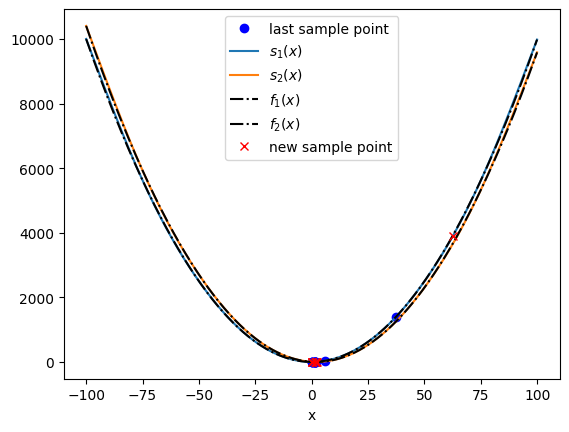

In [8]:
def plotIteration(i):
    i0 = sampleUpToIter[i - 1] if i > 0 else 0
    i1 = sampleUpToIter[i]
    i2 = sampleUpToIter[i + 1]

    plt.plot(sample[i0:i1], f1[i0:i1], "bo", label="last sample point")
    # plt.plot(sample[i0:i1], f2[i0:i1], 'bo')

    s = [RbfModel(), RbfModel()]
    for j in range(2):
        s[j].update(res.sample[:i1, :], res.fsample[:i1, j])

    x = np.arange(-100, 100, 0.1).reshape(-1, 1)
    y1 = s[0](x)[0]
    y2 = s[1](x)[0]
    fx = objf(x)
    f1x = [f[0] for f in fx]
    f2x = [f[1] for f in fx]

    plt.plot(x.flatten(), y1, "-", label=r"$s_1(x)$")
    plt.plot(x.flatten(), y2, "-", label=r"$s_2(x)$")
    plt.plot(x.flatten(), f1x, "k-.", label=r"$f_1(x)$")
    plt.plot(x.flatten(), f2x, "k-.", label=r"$f_2(x)$")

    plt.plot(sample[i1:i2], f1[i1:i2], "rx", label="new sample point")
    # plt.plot(sample[i1:i2], f2[i1:i2], 'rx')

    # plt.plot(sample[i1:i2], np.ones(i2-i1), 'ro', label="new sample")
    plt.xlabel("x")
    plt.legend()
    plt.show()


for i in range(len(sampleUpToIter) - 1):
    plotIteration(i)

In [9]:
# Add last sample to the surrogate models
if surrogateModels[0].ntrain() < sampleUpToIter[-1]:
    objdim = 2
    for i in range(objdim):
        surrogateModels[i].update(
            res.sample[sampleUpToIter[-2] :, :],
            res.fsample[sampleUpToIter[-2] :, i]
        )

surrogateModels[0].ntrain()

100

In [10]:
surrogateModels[0].ntrain()

100

In [11]:
# Continue optimization

maxeval2 = 30
res2 = socemo(
    objf,
    bounds,
    maxeval2,
    surrogateModels=surrogateModels,
    acquisitionFunc=localAcquisition,
    acquisitionFuncGlobal=globalAcquisition,
    disp=True,
)

Iteration: 0
fEvals: 0
Time to update surrogate model: 0.000000 s
Fill gaps in the Pareto front: 1 points in 1.932546 s
Random perturbation of the currently nondominated points: 10 points in 0.131039 s
Minimum point sampling: 1 points in 2.491476 s
Uniform random points and scoring: 1 points in 0.003239 s
Solving the surrogate multiobjective problem: 0 points in 2.201908 s
Number of new sample points:  12
Iteration: 1
fEvals: 12
Time to update surrogate model: 0.000829 s
Fill gaps in the Pareto front: 1 points in 2.103007 s
Random perturbation of the currently nondominated points: 2 points in 0.259165 s
Minimum point sampling: 1 points in 2.673067 s
Uniform random points and scoring: 1 points in 0.003543 s
Solving the surrogate multiobjective problem: 0 points in 1.988881 s
Number of new sample points:  4
Iteration: 2
fEvals: 16
Time to update surrogate model: 0.001799 s
Fill gaps in the Pareto front: 1 points in 2.451698 s
Random perturbation of the currently nondominated points: 0 po

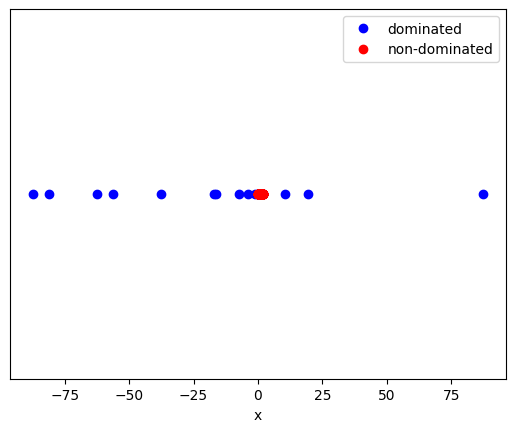

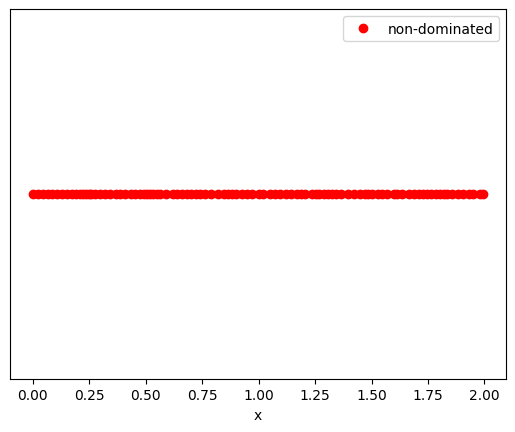

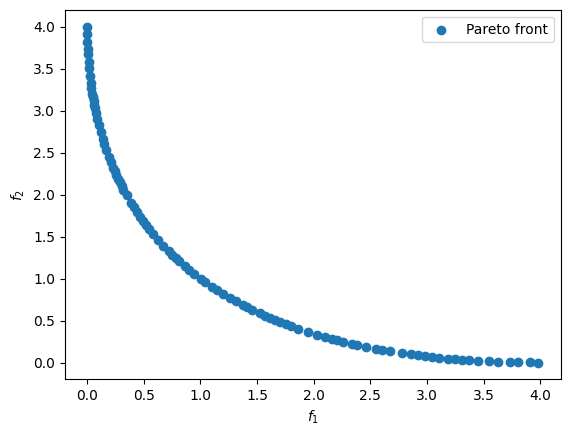

In [12]:
from matplotlib import pyplot as plt

sample = res2.sample.flatten()
f1 = res2.fsample[:, 0].flatten()
f2 = res2.fsample[:, 1].flatten()
nondominated = res2.x
paretoFront = res2.fx

plt.plot(sample, np.ones_like(sample), "bo", label="dominated")
# plt.plot(sample, f2, 'bo')
plt.plot(nondominated, np.ones_like(nondominated), "ro", label="non-dominated")
# plt.plot(nondominated, paretoFront[:,1], 'ro')
plt.xlabel("x")
plt.yticks([], [])
plt.legend()
plt.show()

plt.plot(nondominated, np.ones_like(nondominated), "ro", label="non-dominated")
# plt.plot(nondominated, paretoFront[:,1], 'ro')
plt.xlabel("x")
plt.yticks([], [])
plt.legend()
plt.show()

plt.scatter(res2.fx[:, 0], res2.fx[:, 1], label="Pareto front")
plt.xlabel(r"$f_1$")
plt.ylabel(r"$f_2$")
plt.legend()
plt.show()